In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.031 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

250000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

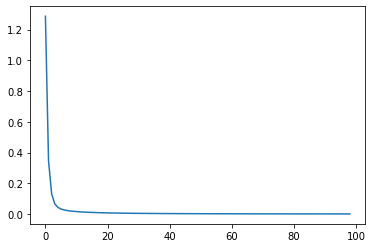

In [8]:
plt.plot(S)

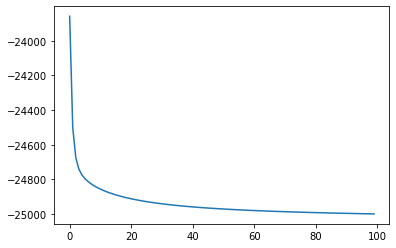

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0006717678747882019

In [11]:
eta

array([-23858.31656878, -24501.52549001, -24675.40199251, -24741.28925837,
       -24774.59682289, -24796.37037387, -24812.80059907, -24826.16817663,
       -24837.52038816, -24847.42114569, -24856.2106802 , -24864.11222181,
       -24871.28184758, -24877.83418689, -24883.85674798, -24889.4184213 ,
       -24894.57479716, -24899.37164114, -24903.84725311, -24908.03412188,
       -24911.96011957, -24915.64938567, -24919.12299616, -24922.39947992,
       -24925.49522427, -24928.42479841, -24931.20121481, -24933.83614315,
       -24936.3400872 , -24938.72253258, -24940.99207108, -24943.1565063 ,
       -24945.22294374, -24947.19786838, -24949.0872117 , -24950.89640983,
       -24952.63045445, -24954.29393722, -24955.89108904, -24957.42581456,
       -24958.90172286, -24960.32215463, -24961.69020638, -24963.00875217,
       -24964.28046287, -24965.50782365, -24966.69314956, -24967.83859963,
       -24968.9461896 , -24970.01780341, -24971.05520364, -24972.06004091,
       -24973.03386258, -

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([1.14108343e+03, 4.97874511e+02, 3.23998008e+02, 2.58110742e+02,
       2.24803178e+02, 2.03029627e+02, 1.86599402e+02, 1.73231824e+02,
       1.61879612e+02, 1.51978855e+02, 1.43189320e+02, 1.35287779e+02,
       1.28118153e+02, 1.21565814e+02, 1.15543253e+02, 1.09981579e+02,
       1.04825203e+02, 1.00028359e+02, 9.55527475e+01, 9.13658787e+01,
       8.74398810e+01, 8.37506149e+01, 8.02770044e+01, 7.70005207e+01,
       7.39047763e+01, 7.09752022e+01, 6.81987858e+01, 6.55638575e+01,
       6.30599134e+01, 6.06774680e+01, 5.84079295e+01, 5.62434943e+01,
       5.41770569e+01, 5.22021322e+01, 5.03127889e+01, 4.85035908e+01,
       4.67695462e+01, 4.51060634e+01, 4.35089116e+01, 4.19741860e+01,
       4.04982777e+01, 3.90778460e+01, 3.77097942e+01, 3.63912484e+01,
       3.51195377e+01, 3.38921770e+01, 3.27068510e+01, 3.15614010e+01,
       3.04538110e+01, 2.93821972e+01, 2.83447970e+01, 2.73399597e+01,
       2.63661380e+01, 2.54218801e+01, 2.45058226e+01, 2.36166837e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_10.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_10.csv', alpha, delimiter = ',')